In [2]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import density

%matplotlib inline
sns.set_theme(style="darkgrid")

DIR_DATASET = r'/Users/dev-rocks/Documents/TCC - Data Science e Big Data/Projeto/datasets/'
# DIR_DATASET = r'C:\Users\Daniel.Vale\Personal\PBDDC\TCC\Projeto_v2\datasets\\'

In [52]:
colunas = ['id','descricaoTipo','tipoDocumento','tema','tokens']

dfProposicoes = pd.read_csv(f'{DIR_DATASET}proposicoesUnificado.csv', sep=';', low_memory=False,usecols=colunas)
dfProposicoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149175 entries, 0 to 149174
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             149175 non-null  int64 
 1   descricaoTipo  149175 non-null  object
 2   tipoDocumento  149175 non-null  object
 3   tema           53268 non-null   object
 4   tokens         147784 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.7+ MB


In [243]:
dfStopWords = pd.read_csv(f'{DIR_DATASET}stop_words.csv', usecols=['stop_words']) \
.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["", ""])

listaStopWords = dfStopWords['stop_words'].values.tolist()

dfStopWords.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   stop_words  637 non-null    object
dtypes: object(1)
memory usage: 5.1+ KB


In [59]:
dfProposicoesClassificadas = dfProposicoes.loc[dfProposicoes['tema'].isna()==False]
dfProposicoesClassificadas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53268 entries, 0 to 149154
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             53268 non-null  int64 
 1   descricaoTipo  53268 non-null  object
 2   tipoDocumento  53268 non-null  object
 3   tema           53268 non-null  object
 4   tokens         53268 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.4+ MB


In [193]:
print('_' * 80)
print(f'CRIANDO DATAFRAMES:')
print(f'[INFO  ] Qtd. de proposições: {len(dfProposicoes)}')
print(f'[INFO  ] Qtd. de proposições classificadas: {len(dfProposicoesClassificadas)}')

print('_' * 80)
print('[INFO  ] Criando dataset para o modelo de aprendizado de máquina')

dfClassificacao = dfProposicoesClassificadas[['tokens', 'tema']]
print(dfClassificacao.describe())

print("." * 80)
print('[INFO  ] LISTA DE TEMAS')
listaTemas = pd.unique(dfClassificacao['tema'].sort_values())
print(listaTemas)

print('_' * 80)
print('[INFO] Dividindo dados de treino e de teste para o modelo de aprendizado')

dfTokens = dfClassificacao['tokens'].values.astype('U')
dfTemas = dfClassificacao['tema'].values.astype('U')



listaStopWords = dfStopWords['stop_words'].values.tolist()

print(f'[INFO  ] Total de stopwords: {len(listaStopWords)}')

________________________________________________________________________________
CRIANDO DATAFRAMES:
[INFO  ] Qtd. de proposições: 149175
[INFO  ] Qtd. de proposições classificadas: 53268
________________________________________________________________________________
[INFO  ] Criando dataset para o modelo de aprendizado de máquina
                                                   tokens   tema
count                                               53268  53268
unique                                              30093     32
top     abre crédito extraordinário ministério cidadan...  Saúde
freq                                                   19   6633
................................................................................
[INFO  ] LISTA DE TEMAS
['Administração Pública' 'Agricultura, Pecuária, Pesca e Extrativismo'
 'Arte, Cultura e Religião' 'Cidades e Desenvolvimento Urbano'
 'Ciência, Tecnologia e Inovação' 'Ciências Exatas e da Terra'
 'Ciências Sociais e Humanas' 'Comunica

In [37]:
def prepararDados(usarHashing=True):

    print('[INFO] Dividindo dados de treino e de teste para o modelo de aprendizado')
    tokens_treino, tokens_teste, temas_treino, temas_teste = train_test_split(dfTokens, dfTemas, test_size=0.20)

    print(f'[INFO  ] Divisão dos dados: Treino={len(tokens_treino) / len(dfTokens)} | Teste={len(tokens_teste) / len(dfTokens)}')
    print(f'[INFO  ] Dados de treino: Tokens={len(tokens_treino)} | Temas={len(temas_treino)}')
    print(f'[INFO  ] Dados de teste: Tokens={len(tokens_teste)} | Temas={len(temas_teste)}')

    print('_' * 80)
    print(f'[INFO. ] Vetorizando o texto das ementas (utilizando Hashing={usarHashing})')
    
    inicio = time()
    
    if (usarHashing):
        vetorizador = HashingVectorizer(stop_words=listaStopWords, alternate_sign=False, n_features=2 ** 4)
        X_train = vetorizador.transform(tokens_treino)
    else:
        vetorizador = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=listaStopWords)
        X_train = vetorizador.fit_transform(tokens_treino)

    duracao = time() - inicio

    print(f'[INFO  ] Vetorização dados de treino finalizada em {duracao}0.2f s')
    print(f"[INFO  ] No. de exemplos (n_samples): %d, No. Features (n_features): %d" % X_train.shape)

    print('.' * 80)
    inicio = time()
    X_test = vetorizador.transform(tokens_teste)
    duracao = time() - inicio
    print(f'[INFO  ] Vetorização dados de teste finalizada em {duracao}0.2f s')
    print(f"[INFO  ] No. de exemplos (n_samples): %d, No. Features (n_features): %d" % X_test.shape)

    return X_train, temas_treino, X_test, temas_teste, listaTemas

In [35]:
def executarModeloClassificacao(rotulo,classificador, X_treino, y_treino, X_teste, y_teste, target_names, imprimirRelatorio=False,
                                imprimirMatrizConfusao=False):
    
    nomeClassificador = f'{str(classificador).split("(")[0]} - {rotulo}'
    print('.' * 80)
    print(f'[INFO  ] TREINANDO O MODELO: {classificador}')
    inicio = time()
    classificador.fit(X_treino, y_treino)
    tempoTreino = time() - inicio
    print(f'[INFO  ] Tempo de treinamento: {tempoTreino:.2f} segundos')

    inicio = time()
    predicao = classificador.predict(X_teste)
    tempoTeste = time() - inicio
    print(f'Tempo de teste: {tempoTeste:.2f} segundos')

    acuracia = metrics.accuracy_score(y_teste, predicao)
    matrizConfusao = metrics.confusion_matrix(y_teste, predicao)
    relatorioClassificao = metrics.classification_report(y_teste,
                                                       predicao,
                                                       target_names=target_names,
                                                       labels=target_names,
                                                        zero_division=0)

    print(f'Acurácia: {acuracia * 100:.2f}')

    print('-' * 80)
    
#     print("RELATÓRIO DE CLASSIFICAÇÃO:")
#     print(relatorioClassificao)
    
#     print('-' * 80)
    
    print('-' * 80)
    print('MATRIZ DE CONFUSAO')
    
    plt.matshow(matrizConfusao)
    plt.title("Matriz de confusão")
    plt.colorbar()
    plt.ylabel("Classificações corretas")
    plt.xlabel("Classificações obtidas")
#     plt.show()
    
    print('-' * 80)
    print('.' * 80)

    return nomeClassificador, acuracia, tempoTreino, tempoTeste, relatorioClassificao, matrizConfusao

In [38]:
resultados = []
X_train, temas_treino, X_test, temas_test, listaTemas = prepararDados(False)


________________________________________________________________________________
CRIANDO DATAFRAMES:
[INFO  ] Qtd. de proposições: 149175
[INFO  ] Qtd. de proposições classificadas: 53268
________________________________________________________________________________
[INFO  ] Criando dataset para o modelo de aprendizado de máquina
                                                   tokens   tema
count                                               53268  53268
unique                                              30093     32
top     abre crédito extraordinário ministério cidadan...  Saúde
freq                                                   19   6633
................................................................................
[INFO  ] LISTA DE TEMAS
['Economia' 'Administração Pública' 'Indústria, Comércio e Serviços'
 'Direitos Humanos e Minorias' 'Comunicações'
 'Direito e Defesa do Consumidor' 'Saúde'
 'Direito Civil e Processual Civil'
 'Meio Ambiente e Desenvolvimento Sustentáv

/usr/local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anexo', 'caput', 'congresso', 'constituição', 'data', 'decreta', 'decreto', 'entra', 'federal', 'gabinete', 'inciso', 'justificação', 'ministro', 'modo', 'nobres', 'pare', 'pares', 'parágrafo', 'passa', 'país', 'publicação', 'redação', 'regimento', 'sala', 'seguinte', 'sessão', 'trata', 'vigor', 'vigorar', 'único'] not in stop_words.
  warnings.warn(


[INFO  ] Vetorização dados de treino finalizada em 74.33924818038940.2f s
[INFO  ] No. de exemplos (n_samples): 42614, No. Features (n_features): 126669
................................................................................
[INFO  ] Vetorização dados de teste finalizada em 19.827249050140380.2f s
[INFO  ] No. de exemplos (n_samples): 10654, No. Features (n_features): 126669


................................................................................
[INFO  ] TREINANDO O MODELO: SGDClassifier(max_iter=50)
[INFO  ] Tempo de treinamento: 6.99 segundos
Tempo de teste: 0.26 segundos
Acurácia: 38.50
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


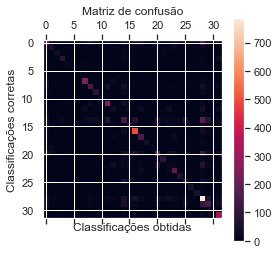

In [39]:
r = executarModeloClassificacao('SGD panalidade l2',SGDClassifier(alpha=0.0001, max_iter=50, penalty='l2'),  X_train, temas_treino, X_test, temas_test, listaTemas)

In [41]:
X_train.shape

(42614, 126669)

## Executar todos os modelos de classificação

SGD panalidade l2
................................................................................
[INFO  ] TREINANDO O MODELO: SGDClassifier(max_iter=50)
[INFO  ] Tempo de treinamento: 7.13 segundos
Tempo de teste: 0.21 segundos
Acurácia: 38.24
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
SGD panalidade l1
................................................................................
[INFO  ] TREINANDO O MODELO: SGDClassifier(max_iter=50, penalty='l1')


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 11.75 segundos
Tempo de teste: 0.09 segundos
Acurácia: 38.17
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
SGD elasticnet
................................................................................
[INFO  ] TREINANDO O MODELO: SGDClassifier(max_iter=50, penalty='elasticnet')


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 13.59 segundos
Tempo de teste: 0.09 segundos
Acurácia: 43.55
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
Linear SVC penalidade l2
................................................................................
[INFO  ] TREINANDO O MODELO: LinearSVC(dual=False, tol=0.001)


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 51.50 segundos
Tempo de teste: 0.07 segundos
Acurácia: 28.33
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
Linear SVC penalidade l1
................................................................................
[INFO  ] TREINANDO O MODELO: LinearSVC(dual=False, penalty='l1', tol=0.001)


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 83.36 segundos
Tempo de teste: 0.08 segundos
Acurácia: 39.36
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
Ridge Classifier
................................................................................
[INFO  ] TREINANDO O MODELO: RidgeClassifier(solver='sag', tol=0.01)


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


[INFO  ] Tempo de treinamento: 59.64 segundos
Tempo de teste: 0.08 segundos
Acurácia: 33.43
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


--------------------------------------------------------------------------------
................................................................................
Perceptron
................................................................................
[INFO  ] TREINANDO O MODELO: Perceptron(max_iter=50)
[INFO  ] Tempo de treinamento: 5.69 segundos
Tempo de teste: 0.08 segundos
Acurácia: 23.42
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
Passive-Aggressive
................................................................................
[INFO  ] TREINANDO O MODELO: PassiveAggressiveClassifier(max_iter=50)


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 13.14 segundos
Tempo de teste: 0.10 segundos
Acurácia: 24.58
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
kNN
................................................................................
[INFO  ] TREINANDO O MODELO: KNeighborsClassifier(n_neighbors=10)
[INFO  ] Tempo de treinamento: 0.08 segundos


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Tempo de teste: 35.18 segundos
Acurácia: 39.50
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
NearestCentroid 
................................................................................
[INFO  ] TREINANDO O MODELO: NearestCentroid()


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 0.23 segundos
Tempo de teste: 0.11 segundos
Acurácia: 43.48
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
 Naive Bayes - MultinomialNB
................................................................................
[INFO  ] TREINANDO O MODELO: MultinomialNB(alpha=0.01)


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 0.54 segundos
Tempo de teste: 0.08 segundos
Acurácia: 34.40
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
 Naive Bayes - BernoulliNB
................................................................................
[INFO  ] TREINANDO O MODELO: BernoulliNB(alpha=0.01)


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 0.59 segundos
Tempo de teste: 0.19 segundos
Acurácia: 23.25
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
 Naive Bayes - ComplementNB
................................................................................
[INFO  ] TREINANDO O MODELO: ComplementNB(alpha=0.01)


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 0.56 segundos
Tempo de teste: 0.08 segundos
Acurácia: 34.90
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................
LinearSVC c/ feature selection
................................................................................
[INFO  ] TREINANDO O MODELO: Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[INFO  ] Tempo de treinamento: 97.89 segundos
Tempo de teste: 0.07 segundos
Acurácia: 31.11
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MATRIZ DE CONFUSAO
--------------------------------------------------------------------------------
................................................................................


/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/3338144327.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


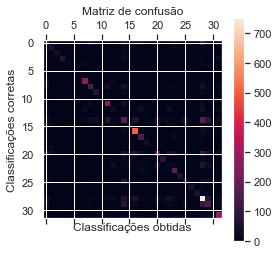

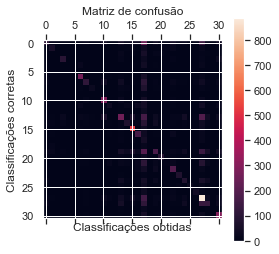

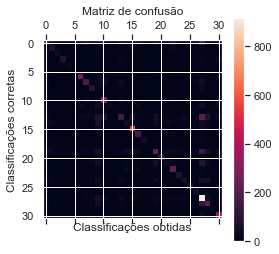

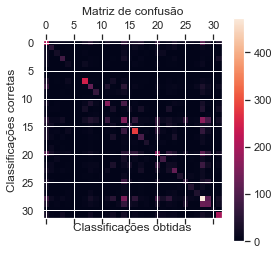

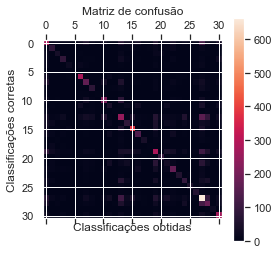

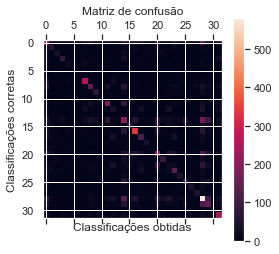

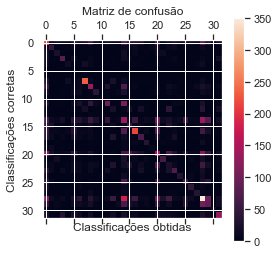

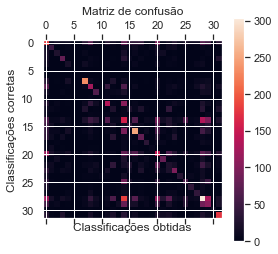

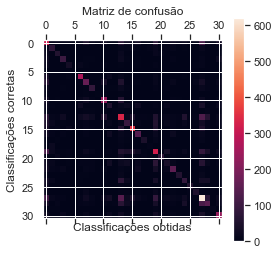

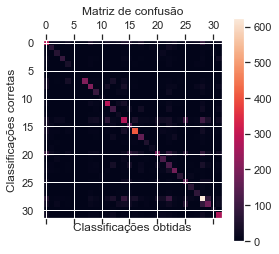

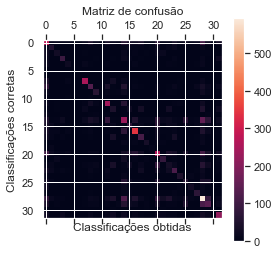

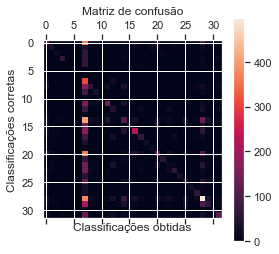

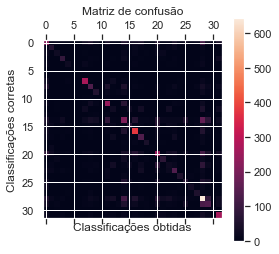

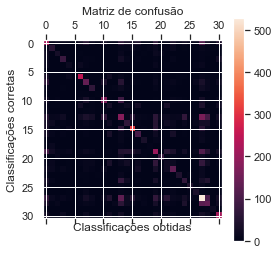

In [42]:
listaModelos = [
  (SGDClassifier(alpha=0.0001, max_iter=50, penalty='l2'), 'SGD panalidade l2'),
  (SGDClassifier(alpha=0.0001, max_iter=50, penalty='l1'), 'SGD panalidade l1'),
  (SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"),'SGD elasticnet'),
  (LinearSVC(penalty='l2', dual=False, tol=1e-3), 'Linear SVC penalidade l2'),
  (LinearSVC(penalty='l1', dual=False, tol=1e-3), 'Linear SVC penalidade l1'),
  (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
  (Perceptron(max_iter=50), "Perceptron"),
  (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
  (KNeighborsClassifier(n_neighbors=10), "kNN"),
  # (RandomForestClassifier(), "Random forest"),
  # (MLPClassifier(max_iter=100, random_state=1, verbose=False), 'MLP Classifier'),
  (NearestCentroid(), 'NearestCentroid '),
  (MultinomialNB(alpha=0.01), ' Naive Bayes - MultinomialNB'),
  (BernoulliNB(alpha=0.01), ' Naive Bayes - BernoulliNB'),
  (ComplementNB(alpha=0.01), ' Naive Bayes - ComplementNB'),
  (Pipeline(
    [
      (
          "feature_selection",
          SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
      ),
      ("classification", LinearSVC(penalty="l2")),
    ]
  ), 'LinearSVC c/ feature selection')
]

for classificador, rotulo in listaModelos:
    print("=" * 80)
    print(rotulo)
    resultados.append(executarModeloClassificacao(rotulo,classificador, X_train, temas_treino, X_test, temas_test, listaTemas))

................................................................................
[INFO  ] TREINANDO O MODELO: SGDClassifier(max_iter=50, penalty='elasticnet')
[INFO  ] Tempo de treinamento: 12.25 segundos
Tempo de teste: 0.15 segundos
Acurácia: 42.74
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

                                   Economia       0.32      0.15      0.20       534
                      Administração Pública       0.39      0.29      0.33      1644
             Indústria, Comércio e Serviços       0.25      0.04      0.07       587
                Direitos Humanos e Minorias       0.39      0.12      0.19      1785
                               Comunicações       0.70      0.67      0.69       677
             Direito e Defesa do Consumidor       0.26      0.24      0.25       393
                                      Saúde 

/var/folders/c4/7wg21tps309953_4v53mpswm0000gn/T/ipykernel_9864/770350128.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


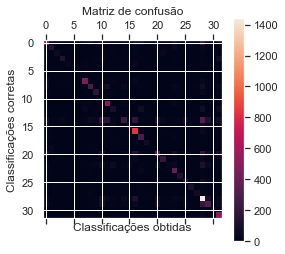

--------------------------------------------------------------------------------
................................................................................


In [30]:
resultadoSGD =executarModeloClassificacao('SGD Classifier - elasticnet',
    SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"),
    X_train, 
    temas_treino,
    X_test, 
    temas_test, 
    listaTemas)


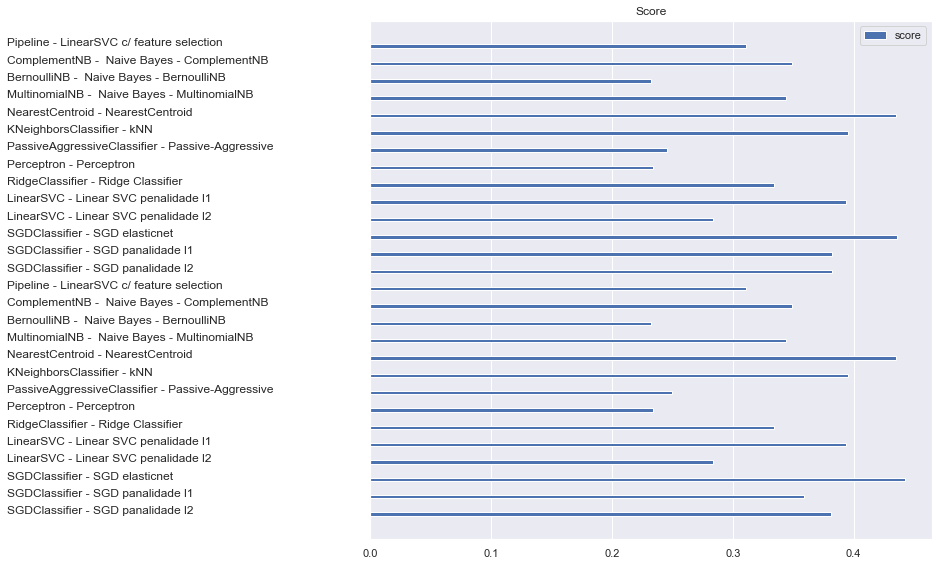

In [43]:
indices = np.arange(len(resultados))

results = [[x[i] for x in resultados] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score")
#plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
#plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()

In [44]:
dfResultado = pd.DataFrame(resultados,columns=['Modelo','Score','Tempo Treino','Tempo Teste','Matriz Confusão','Relatório'])
dfResultado.drop(['Matriz Confusão','Relatório'],inplace=True,axis=1)

dfResultado.sort_values(by=['Score'],ascending=False)

,Modelo,Score,Tempo Treino,Tempo Teste
2,SGDClassifier - SGD elasticnet,0.442275,17.390600,0.104611
16,SGDClassifier - SGD elasticnet,0.435517,13.590308,0.089571
23,NearestCentroid - NearestCentroid,0.434766,0.225615,0.108818
9,NearestCentroid - NearestCentroid,0.434766,0.231815,0.107766
22,KNeighborsClassifier - kNN,0.394969,0.082276,35.176481
8,KNeighborsClassifier - kNN,0.394969,0.093677,34.811772
18,LinearSVC - Linear SVC penalidade l1,0.393561,83.359357,0.078029
4,LinearSVC - Linear SVC penalidade l1,0.393467,86.057998,0.080249
14,SGDClassifier - SGD panalidade l2,0.382392,7.131372,0.207805
15,SGDClassifier - SGD panalidade l1,0.381735,11.750196,0.092801


In [184]:
df = pd.crosstab(index=[dfProposicoesClassificadas['id'],dfProposicoesClassificadas['tokens']],
                           columns=dfProposicoesClassificadas['tema'])

df.head(10)

tema                                                       Administração Pública  \
id     tokens                                                                      
308880 redação arts decreto novembro dispõe nacional s...                      0   
317970 altera junho regulamenta inciso constituição fe...                      1   
427339 altera maio regula direitos obrigações relativo...                      0   
459323 acrescenta consolidação leis estabelecer multa ...                      0   
498347 altera maio dispor cobrança pedágio ementa alte...                      0   
501638 institui programa cidade amiga idoso icardo tri...                      0   
512431 proíbe utilização mensagens subliminares propag...                      0   
530357 obriga fabricantes aparelho celular disponibili...                      0   
538196 dispõem proibição eliminação cães gatos órgãos ...                      0   
539990 altera novembro dispõe registro público empresa...                      0   

tema                                                       Agricultura, Pecuária, Pesca e Extrativismo  \
id     tokens                                                                                            
308880 redação arts decreto novembro dispõe nacional s...                                            0   
317970 altera junho regulamenta inciso constituição fe...                                            0   
427339 altera maio regula direitos obrigações relativo...                                            0   
459323 acrescenta consolidação leis estabelecer multa ...                                            0   
498347 altera maio dispor cobrança pedágio ementa alte...                                            0   
501638 institui programa cidade amiga idoso icardo tri...                                            0   
512431 proíbe utilização mensagens subliminares propag...                                            0   
530357 obriga fabricantes aparelho celular disponibili...                                            0   
538196 dispõem proibição eliminação cães gatos órgãos ...                                            0   
539990 altera novembro dispõe registro público empresa...                                            0   

tema                                                       Arte, Cultura e Religião  \
id     tokens                                                                         
308880 redação arts decreto novembro dispõe nacional s...                         0   
317970 altera junho regulamenta inciso constituição fe...                         0   
427339 altera maio regula direitos obrigações relativo...                         0   
459323 acrescenta consolidação leis estabelecer multa ...                         0   
498347 altera maio dispor cobrança pedágio ementa alte...                         0   
501638 institui programa cidade amiga idoso icardo tri...                         0   
512431 proíbe utilização mensagens subliminares propag...                         0   
530357 obriga fabricantes aparelho celular disponibili...                         0   
538196 dispõem proibição eliminação cães gatos órgãos ...                         0   
539990 altera novembro dispõe registro público empresa...                         0   

tema                                                       Cidades e Desenvolvimento Urbano  \
id     tokens                                                                                 
308880 redação arts decreto novembro dispõe nacional s...                                 0   
317970 altera junho regulamenta inciso constituição fe...                                 0   
427339 altera maio regula direitos obrigações relativo...                                 0   
459323 acrescenta consolidação leis estabelecer multa ...                                 0   
498347 altera maio dispor cobrança pedágio ementa alte...                                 0   
501638 i

In [219]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

tokens = [i[1] for i in df.index.values.tolist()]
temas = df.values.tolist()

In [233]:
tokens_treino, tokens_teste, temas_treino, temas_teste = train_test_split(tokens,temas,test_size=0.01)

In [1]:
vetorizador = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=listaStopWords)
X_treino = vetorizador.fit_transform(tokens_treino)
X_teste = vetorizador.fit_transform(tokens_teste)



# print(tokens_teste)
print(X_teste.shape)
len(temas_teste)


NameError: name 'TfidfVectorizer' is not defined

In [241]:
clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10)).fit(X_treino, temas_treino)
predicao = clf.predict(X_teste[7])

predicao

ValueError: X has 12298 features, but KNeighborsClassifier is expecting 133120 features as input.

In [ ]:
acuracia = metrics.accuracy_score(temas_teste, predicao)
acuracia

In [206]:
X[145]


'inclui rodovias anexo setembro dispõe plano nacional viação rômulo gouveia inclui rodovias anexo setembro dispõe plano nacional viação congresso nacional decreta inclui rodovias descritiva rodovias rodoviário federal constante anexo setembro institui plano nacional viação descritiva rodovias rodoviário federal aprovado passa vigorar acrescido seguintes rodovias descritiva rodovias rodoviário federal passagem unidades federação extensã superposiç entroncamento santa cruz japi damião casserengue arara areia alagoa juarez távora entroncamento entroncamento goiana pedras fogo juripiranga pilar gurinhém mulungu alagoinha cuitegi pilões serraria arara barra santa rosa picuí entroncamento jardim seridó numeração traçado definitivo rodovias trata definidos órgão competente entra vigor data publicação justificação presente objetivo incluir plano nacional viação rodovias corta estados nordestinos norte paraíba pernambuco corta paraíba termina norte início chegada rodovias federais existentes tr

In [238]:
pred = clf.predict(X_teste[145])
pred

ValueError: X has 12298 features, but KNeighborsClassifier is expecting 133120 features as input.

In [207]:
for i,val in enumerate(pred[0]):
    if val:
        print (listaTemas[i])

Viação, Transporte e Mobilidade


In [208]:
y[145]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]